In [ ]:
import os
import time

import pandas as pd
import plotly.graph_objects as go
import tensorflow as tf
from keras.callbacks import TensorBoard
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.preprocessing.image import ImageDataGenerator

MODEL_NAME = "MegaClassifier_a"
VERSION_BASE = "v1"

EPOCHS = 2
BATCH_SIZES = [16]
IMAGE_SIZE = (224, 224)
IMAGE_SHAPE = IMAGE_SIZE + (3,)
SEED = 42

DATASET_CSV = os.path.abspath("./data/processed/onlyDetectionsForTrain/onlyDetectionsForTrain.csv")
DATASET_PATH = os.path.dirname(DATASET_CSV)

dataset = pd.read_csv(DATASET_CSV, sep=";")
dataset['file_name'] = dataset['file_name'].apply(lambda x: os.path.join(DATASET_PATH, x))
dataset['binary_label'] = dataset['binary_label'].astype(str)

train_df = dataset[dataset['subset'] == 'train']
validation_df = dataset[dataset['subset'] == 'validation']
test_df = dataset[dataset['subset'] == 'test']


def train_and_evaluate(batch_size, VERSION_INDEX):
    print(f"\n🔹 Entrenando con batch_size={batch_size} 🔹")

    train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)
    datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

    train_images = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col="file_name",
        y_col="binary_label",
        target_size=IMAGE_SIZE,
        batch_size=batch_size,
        class_mode="binary",
        shuffle=True,
        seed=SEED,
    )
    validation_images = datagen.flow_from_dataframe(
        dataframe=validation_df,
        x_col="file_name",
        y_col="binary_label",
        target_size=IMAGE_SIZE,
        batch_size=batch_size,
        class_mode="binary",
        shuffle=True,
        seed=SEED,
    )
    global test_images
    test_images = datagen.flow_from_dataframe(
        dataframe=test_df,
        x_col="file_name",
        y_col="binary_label",
        target_size=IMAGE_SIZE,
        batch_size=batch_size,
        class_mode="binary",
        shuffle=False,
        seed=SEED,
    )

    mobilenet_v2 = tf.keras.applications.MobileNetV2(
        weights="imagenet",
        include_top=False,
        input_shape=IMAGE_SHAPE,
    )
    mobilenet_v2.trainable = False

    model = tf.keras.Sequential([
        mobilenet_v2,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ], name=f"{MODEL_NAME}_{VERSION_BASE}{VERSION_INDEX}")

    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=["accuracy", Precision(name="precision"), Recall(name="recall"), AUC(name="auc")],
    )

    start_time = time.time()
    history = model.fit(
        train_images,
        epochs=EPOCHS,
        validation_data=validation_images,
        callbacks=[
            TensorBoard(log_dir=f"./logs/{MODEL_NAME}/{VERSION_BASE}/{VERSION_BASE}.{VERSION_INDEX}"),
        ]
    )
    training_time = time.time() - start_time

    os.makedirs(f"./models/{MODEL_NAME}/{VERSION_BASE}", exist_ok=True)
    model.save(f"./models/{MODEL_NAME}/{VERSION_BASE}/{VERSION_BASE}_{VERSION_INDEX}")

    history_df = pd.DataFrame(history.history)
    os.makedirs(f"./logs/{MODEL_NAME}/{VERSION_BASE}/{VERSION_BASE}.{VERSION_INDEX}", exist_ok=True)
    history_df.to_csv(f"./logs/{MODEL_NAME}/{VERSION_BASE}/{VERSION_BASE}.{VERSION_INDEX}/history.csv", index=False)

    results = model.evaluate(test_images)

    metric_names = history.model.metrics_names
    evaluation_results = {("test_" + name): value for name, value in zip(metric_names, results)}
    evaluation_results["batch_size"] = batch_size
    evaluation_results["training_time"] = training_time

    results_df = pd.DataFrame([evaluation_results])
    results_df.to_csv(f"./logs/{MODEL_NAME}/{VERSION_BASE}/{VERSION_BASE}.{VERSION_INDEX}/results.csv", index=False)

    print(f"\n📉 Loss: {results[0]:.4f}")
    print(f"🎯 Accuracy: {results[1]:.4%}")
    print(f"✅ Precision: {results[2]:.4%}")
    print(f"🔄 Recall: {results[3]:.4%}")
    print(f"📊 AUC: {results[4]:.4f}")
    print(f"⏳ Tiempo de entrenamiento: {training_time:.2f} segundos")

    return results_df


all_results = []
count = 0
for batch_size in BATCH_SIZES:
    results_df = train_and_evaluate(batch_size, count)
    all_results.append(results_df)
    count += 1

final_results = pd.concat(all_results, ignore_index=True)
final_results.to_csv(f"./logs/{MODEL_NAME}/{VERSION_BASE}/batch_comparison_results.csv", index=False)

print("\n✅ ¡Entrenamiento con diferentes batch sizes completado!")

In [26]:
import numpy as np
from sklearn.metrics import roc_curve, auc

MODEL_NAME = "MegaClassifier_a"
VERSION_BASE = "v1"

model = tf.keras.models.load_model(f"./models/{MODEL_NAME}/{VERSION_BASE}/{VERSION_BASE}_0")

# Obtener probabilidades de predicción
y_pred_probs = model.predict(test_images).flatten()  # Probabilidades de clase

# Obtener etiquetas reales
y_true = test_images.classes  # Etiquetas verdaderas del dataset de prueba

# Calcular valores para la curva ROC
fpr, tpr, _ = roc_curve(y_true, y_pred_probs)  # Falsos positivos, verdaderos positivos
roc_auc = auc(fpr, tpr)  # Área bajo la curva

# Encontrar el umbral óptimo (punto más lejano a la diagonal)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print(f"\n✅ Umbral óptimo basado en ROC: {optimal_threshold:.4f}")

# Mostrar el valor de AUC
print(f"\n✅ Área Bajo la Curva ROC (AUC): {roc_auc:.4f}")

2025-02-25 08:09:04.266122: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


268/268 [==============================] - 11s 39ms/step

✅ Umbral óptimo basado en ROC: 0.5739

✅ Área Bajo la Curva ROC (AUC): 0.9853


In [27]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=fpr, y=tpr, mode="lines", name=f"{MODEL_NAME} {VERSION_BASE} (AUC = {roc_auc:.4f})"
    )
)

fig.add_trace(
    go.Scatter(
        x=[0, 1],
        y=[0, 1],
        mode="lines",
        name="Random Classifier",
        line=dict(dash="dash"),
    )
)

fig.update_layout(
    # Receiver Operating Characteristic (ROC)
    title=f"ROC Curve - {MODEL_NAME} {VERSION_BASE}",
    xaxis_title="False Positive Rate",
    yaxis_title="True Positive Rate",
    legend_title="Curves",
    template="seaborn",
    width=700,
    height=500,
    xaxis=dict(
        tickmode="linear",
        tick0=0,
        dtick=0.1,
    ),
)

fig.show()
# fig.write_image(f"./reports/graphics/results_roc_{MODEL_NAME}_{VERSION}.png")

In [24]:

import pandas as pd
from sklearn.metrics import confusion_matrix

# Obtener las etiquetas reales
y_true = test_images.classes  # Etiquetas verdaderas del dataset de prueba

# Obtener predicciones del modelo
y_pred_probs = model.predict(test_images)  # Probabilidades de clase
y_pred = (y_pred_probs >= 0.5739).astype(int).flatten()  # Convertir a etiquetas binarias (0 o 1)

# Calcular matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)

# Convertir la matriz a texto para la visualización en la gráfica
conf_matrix_text = [[str(value) for value in row] for row in conf_matrix]

# Mostrar la matriz de confusión en consola
conf_matrix_df = pd.DataFrame(conf_matrix, index=["No Animal", "Animal"], columns=["No Animal", "Animal"])
print("\n✅ Matriz de Confusión:\n", conf_matrix_df)

268/268 [==============================] - 11s 39ms/step

✅ Matriz de Confusión:
            No Animal  Animal
No Animal       1369      81
Animal           200    2636


In [25]:
fig = go.Figure(
    data=go.Heatmap(
        z=conf_matrix,
        x=["No Animal", "Animal"],  # Predicciones
        y=["No Animal", "Animal"],  # Clases reales
        text=conf_matrix_text,
        texttemplate="%{text}",
        colorscale="Blues",
        showscale=True,
    )
)

fig.update_layout(
    title=f"Confusion Matrix - {MODEL_NAME}",
    xaxis_title="Predicted Labels",
    yaxis_title="Actual Labels",
    xaxis=dict(tickmode="array", tickvals=[0, 1], ticktext=["No Animal", "Animal"]),
    yaxis=dict(tickmode="array", tickvals=[0, 1], ticktext=["No Animal", "Animal"]),
    template="seaborn",
    width=600,
    height=600,
    font=dict(size=14),
)

fig.show()

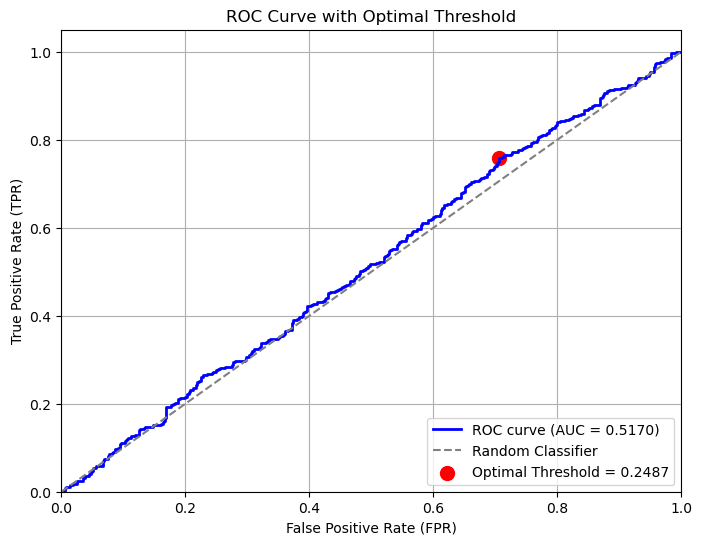

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Simulación de etiquetas reales y probabilidades de predicción
np.random.seed(42)
y_true = np.random.randint(0, 2, 1000)  # Etiquetas verdaderas (0 o 1)
y_pred_probs = np.random.rand(1000)  # Probabilidades simuladas

# Calcular la Curva ROC
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Encontrar el umbral óptimo (punto más lejano de la diagonal aleatoria)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# Graficar la Curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--", label="Random Classifier")  # Diagonal aleatoria

# Marcar el punto óptimo
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color="red", label=f"Optimal Threshold = {optimal_threshold:.4f}", s=100)

# Configurar el gráfico
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve with Optimal Threshold")
plt.legend(loc="lower right")
plt.grid(True)

# Mostrar la gráfica
plt.show()

In [29]:
y_pred = (y_pred_probs >= optimal_threshold).astype(int)